In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import gym
from gym_utils_q_learning import AtariEnv
from gym_utils_q_learning import AtariFrame
from AtariACModels import AtariActorModel, AtariCriticModel
import numpy as np
import random

#environment_name = "SpaceInvaders-v4"
#environment_name  = "SpaceInvadersNoFrameskip-v4"
environment_name = 'DemonAttackNoFrameskip-v4'

# environment_name = "Pong-v4"
# typical_bad_game_frame_count = 1100
# reward_frame_shift = -1

action_count = gym.make(environment_name).action_space.n

In [14]:
#play a game. feed each frame into the model and see what we get
import time 

def play_game(atari_env, model, epsilon, max_frames=5000, debug=False):
    current_action = 0
    done = False
    frame_counter = 0
    action_count = atari_env.env.action_space.n
    choices = np.arange(action_count)
    
    while not done:
        save_step = frame_counter >= 60
        atari_frame = atari_env.step(current_action, save_step=save_step)

        if atari_frame is None:  #processed_frames == None
            done = True
            continue
            
        processed_frames = atari_frame.get_processed_frames()

        processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
        img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
        output = model(img_tensor)
        action_array = output.detach().cpu().numpy()[0]
        if debug:
            time.sleep(2/60)
            print("actions from model: {}".format(action_array))
            
            #action_for_critic_reshaped = np.reshape(action_array, (1, 1))
            action_for_critic_reshaped = np.zeros((1,1))
            action_for_critic_reshaped[0][0] = current_action
            action_for_critic_reshaped = action_batch_to_one_hot(action_count, action_for_critic_reshaped)
            action_for_critic_tensor = torch.from_numpy(action_for_critic_reshaped).float().cuda()
            
            critic_model_target.eval()
            critic_val = critic_model_target(img_tensor, action_for_critic_tensor)
            critic_model_target.train()
            print("critic val for action: {} = {}".format(action_for_critic_tensor, critic_val))
    
        rand = random.uniform(0, 1)
        if rand < epsilon:
            current_action = atari_env.env.action_space.sample()
        else:
            #current_action = np.argmax(action_array)
            current_action = np.random.choice(choices, p=action_array)

        frame_counter += 1
        if frame_counter > max_frames:
            break

def game_step(atari_env, model, epsilon, max_frames=3000):
    current_action = 0
    done = False
    
    frame = atari_env.frame_buffer[-1]
    processed_frames = frame.get_next_processed_frames()

    processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
    img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
    output = model(img_tensor)
    action_array = output.detach().cpu().numpy()[0]

    rand = random.uniform(0, 1)
    if rand < epsilon:
        current_action = atari_env.env.action_space.sample()
    else:
        current_action = np.argmax(action_array)

    atari_frame = atari_env.step(current_action, save_step=save_step)

    if atari_frame is None:
        return True
    
    return False

            
def get_train_batch(atari_env, batch_size, lambda_frames, gamma):
    rand_arr = np.arange(len(atari_env.frame_buffer)-1-lambda_frames)
    np.random.shuffle(rand_arr)
   
    index_counter = 0
    batch_index_counter = 0
    
    frame_batch        = np.zeros((batch_size, 4, 210, 160))
    next_frame_batch   = np.zeros((batch_size, 4, 210, 160))
    reward_batch       = np.zeros(batch_size)
    actions_batch      = np.zeros(batch_size)
    next_actions_batch = np.zeros(batch_size)
    frame_number_batch = np.zeros(batch_size)
    lambda_reward      = np.zeros(batch_size)
    
    for batch_index in range(batch_size):
        frame_number = rand_arr[batch_index]
        
        for i in range(lambda_frames):
            lambda_reward[batch_index] += gamma**(i+1) * atari_env.frame_buffer[frame_number+i].getReward()
        
        atari_frame = atari_env.frame_buffer[frame_number]
        next_atari_frame = atari_env.frame_buffer[frame_number+1]
        lambda_end_atari_frame = atari_env.frame_buffer[frame_number+lambda_frames]
        
        frame_batch[batch_index]      = atari_frame.get_processed_frames()
        next_frame_batch[batch_index] = lambda_end_atari_frame.get_next_processed_frames()
        reward_batch[batch_index]     = atari_frame.getReward()
        actions_batch[batch_index]    = atari_frame.action_taken
        #next_actions_batch[batch_index] = next_atari_frame.action_taken
        next_actions_batch[batch_index] = lambda_end_atari_frame.action_taken
        frame_number_batch[batch_index] = frame_number

    return frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch, lambda_reward
    
def action_batch_to_one_hot(action_count, action_batch):
#     print(action_batch.shape)
#     print(action_batch)
    return_value = np.zeros((action_batch.shape[0], action_count))
    for i in range(action_batch.shape[0]):
        this_row = np.zeros(action_count)
#         print("action_batch[i][0]: {}".format(action_batch[i][0]))
        this_row[int(action_batch[i][0])] = 1.0
        return_value[i] = this_row
    return return_value
    
    

def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        

In [3]:
actor_model_local  = AtariActorModel(action_count).cuda()
actor_model_target = AtariActorModel(action_count).cuda()

critic_model_local  = AtariCriticModel(action_count).cuda()
critic_model_target = AtariCriticModel(action_count).cuda()

atari_env_train = AtariEnv(environment_name)


In [ ]:
learning_rate_actor = .0001 #.000005
learning_rate_critic = .001 #.000005
actor_optimizer = optim.Adam(actor_model_local.parameters(), lr=learning_rate_actor)
critic_optimizer = optim.Adam(critic_model_local.parameters(), lr=learning_rate_critic)

epochs = 100 #100
gamma = .98
lambda_frames = 10
TAU = .001 #1e-3  

epsilon_max = 0.30
epsilon_min = 0.10
epsilon_decay_frames = 50000
trainings_per_epoch = 50
batch_size = 128

best_score = 28.0
best_score_actor_model_local = actor_model_local

for epoch in range(epochs):
    total_critic_loss = 0
    total_actor_loss = 0
    
    #play a game. game info is saved to the AtariEnv object
    atari_env_train.reset()     
    epsilon = epsilon_max - (epsilon_max-epsilon_min)*(atari_env_train.global_step_counter/epsilon_decay_frames)
    epsilon = max(epsilon_min, epsilon)
    actor_model_local.eval()
    play_game(atari_env_train, actor_model_local, epsilon)  
    actor_model_local.train()
    
    game_score = atari_env_train.current_score
    if game_score < (best_score * 0.9):
        #assume the last round of training made the model worse. replace the current actor
        #model with the one that had a better score and train wth it
        actor_model_local = best_score_actor_model_local
        print("\nBacking out the last training performed on the local actor model.  game score: {}".format(game_score))
    else:
        best_score = game_score
        best_score_actor_model_local = actor_model_local
        print("\nSetting the best score/actor model. game score: {}".format(game_score))
        
    for training_iter in range(trainings_per_epoch):
        
        # TODO - instead of palying a whole game, move forward one step and train a batch.
        
        if atari_env_train.global_step_counter < 10000:
            continue
        
        frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch, lambda_reward_batch = get_train_batch(atari_env_train, batch_size, lambda_frames, gamma)

        # print(frame_batch.shape)
        # print(next_frame_batch.shape)
        # print(actions_batch)
        # print(reward_batch)
        # print(frame_number_batch)

        # convert to tensors for input into the models.
        reward_batch_reshaped = np.reshape(reward_batch, (batch_size, 1))   #unsqueeze?
        reward_batch_tensor = torch.from_numpy(reward_batch_reshaped).float().cuda()
        
        img_tensor = torch.from_numpy(frame_batch).float().cuda()
        img_tensor_next = torch.from_numpy(next_frame_batch).float().cuda()
        
        actions_batch_reshaped = np.reshape(actions_batch, (batch_size, 1))
        actions_batch_reshaped = action_batch_to_one_hot(action_count, actions_batch_reshaped)
        actions_batch_tensor = torch.from_numpy(actions_batch_reshaped).float().cuda()
        #print("actions_batch_tensor: {}".format(actions_batch_tensor))
        
        #next_actions_batch_reshaped = np.reshape(next_actions_batch, (batch_size, 1))
        #next_actions_batch_reshaped = action_batch_to_one_hot(action_count, next_actions_batch_reshaped)
        #next_actions_batch_tensor = torch.from_numpy(next_actions_batch_reshaped).float().cuda()
        #print("next_actions_batch_tensor: {}".format(next_actions_batch_tensor))
        
        lambda_reward_batch_reshaped = np.reshape(lambda_reward_batch, (batch_size, 1))
        lambda_reward_batch_tensor = torch.from_numpy(lambda_reward_batch_reshaped).float().cuda()
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models

        # Compute Q targets for current states (y_i)
        ##### instead of using historical next actions, use the target actor model for next actions
        target_actions_next = actor_model_target(img_tensor_next)
        #Q_targets_next = critic_model_target(img_tensor_next, next_actions_batch_tensor) #note "next" values are end of lambda frames
        Q_targets_next = critic_model_target(img_tensor_next, target_actions_next) #note "next" values are end of lambda frames
        
        #Q_targets = reward_batch_tensor + (gamma * Q_targets_next)
        Q_targets = lambda_reward_batch_tensor + (gamma**lambda_frames * Q_targets_next)
            
        # Compute critic loss
        Q_expected = critic_model_local(img_tensor, actions_batch_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
            
        # Minimize the critic loss
        critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(critic_model_local.parameters(), 1)
        critic_optimizer.step()
        total_critic_loss += critic_loss.item()
            
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = actor_model_local(img_tensor)
        actor_loss = -critic_model_local(img_tensor, actions_pred).mean()
            
        # Minimize the actor loss
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        total_actor_loss += actor_loss.item()
            
        # ----------------------- update target networks ----------------------- #
        #use very small Tau and update with every step
        soft_update(critic_model_local, critic_model_target, TAU)
        soft_update(actor_model_local, actor_model_target, TAU)

    print("epoch: {}, score: {}, epsilon: {:.3f}, frames ran: {}, critic loss: {:.6f}, actor_loss: {:.6f}".format(epoch, atari_env_train.current_score, epsilon, atari_env_train.global_step_counter, total_critic_loss/trainings_per_epoch, total_actor_loss/trainings_per_epoch))
    
atari_env_train.close()


Backing out the last training performed on the local actor model.  game score: 12.0
epoch: 0, score: 12.0, epsilon: 0.100, frames ran: 955968, critic loss: 0.066834, actor_loss: -0.198244

Backing out the last training performed on the local actor model.  game score: 10.0
epoch: 1, score: 10.0, epsilon: 0.100, frames ran: 959164, critic loss: 0.074561, actor_loss: -0.189139

Backing out the last training performed on the local actor model.  game score: 15.0
epoch: 2, score: 15.0, epsilon: 0.100, frames ran: 979168, critic loss: 0.073689, actor_loss: -0.160766

Backing out the last training performed on the local actor model.  game score: 21.0
epoch: 3, score: 21.0, epsilon: 0.100, frames ran: 986708, critic loss: 0.055159, actor_loss: -0.175405

Backing out the last training performed on the local actor model.  game score: 15.0
epoch: 4, score: 15.0, epsilon: 0.100, frames ran: 1006712, critic loss: 0.041607, actor_loss: -0.192910

Backing out the last training performed on the local 

In [12]:
torch.save(best_score_actor_model_local.state_dict(), "demonattack_actor_local.pt")
torch.save(actor_model_target.state_dict(), "demonattack_actor_target.pt")
torch.save(critic_model_local.state_dict(), "demonattack_critic_local.pt")
torch.save(critic_model_target.state_dict(), "demonattack_critic_target.pt")




In [13]:
actor_model_local.load_state_dict(torch.load("demonattack_actor_local.pt"))
actor_model_target.load_state_dict(torch.load("demonattack_actor_target.pt"))

critic_model_local.load_state_dict(torch.load("demonattack_critic_local.pt"))
critic_model_target.load_state_dict(torch.load("demonattack_critic_target.pt"))



#play a game using the model
play_environment_name = 'DemonAttackNoFrameskip-v4'
atari_env_play = AtariEnv(play_environment_name)
play_model = best_score_actor_model_local

for i in range(1):
    atari_env_play.reset()

    play_model.eval()
    play_game(atari_env_play, play_model, 0.05, max_frames=2000, debug=True)
    print("score: {}".format(atari_env_play.current_score))
    play_model.train()

atari_env_play.close()

actions from model: [2.47623015e-04 1.12930786e-04 4.03498998e-05 1.93180442e-02
 9.78887737e-01 1.39328674e-03]
critic val for action: tensor([[1., 0., 0., 0., 0., 0.]], device='cuda:0') = tensor([[0.9339]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.5433069e-04 7.9628917e-05 2.9732288e-05 1.3143879e-02 9.8598099e-01
 6.1138120e-04]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.9639]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.8887143e-04 1.3844181e-04 5.2845553e-05 5.1850360e-02 9.4663638e-01
 1.1331401e-03]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.8765]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.7691044e-04 3.2277135e-04 1.5321092e-04 3.4074441e-01 6.5686959e-01
 1.4331453e-03]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.9317]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from m

actions from model: [1.79011568e-06 6.87212037e-07 1.17185614e-07 5.43713510e-01
 4.56283897e-01 8.03935668e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.8015]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.0945273e-08 8.4219369e-09 1.9478028e-09 1.2620326e-02 9.8737967e-01
 2.0706296e-14]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.9665]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.4466233e-10 4.2996184e-10 1.8669416e-10 5.9663774e-03 9.9403363e-01
 5.3218326e-17]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.9664]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.1630554e-09 1.5931926e-09 8.9440760e-10 1.5939313e-01 8.4060681e-01
 3.2032054e-16]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.0742]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from m

actions from model: [4.1472831e-07 4.1945971e-09 1.2921494e-09 5.7396844e-02 9.4260269e-01
 1.4615469e-16]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.7751]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.7323129e-05 1.6898809e-07 6.4666338e-08 7.3819286e-01 2.6178959e-01
 5.7167156e-13]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.6590]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.52323155e-05 2.62113218e-07 8.82951880e-08 9.47326660e-01
 5.26577979e-02 1.78253350e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.0512]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.5364075e-06 8.0293916e-08 2.3951806e-08 9.9899155e-01 1.0058560e-03
 7.0041230e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.9844]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from m

actions from model: [6.2646814e-06 4.1616954e-06 1.6425367e-06 9.9826813e-01 1.7048890e-03
 1.5050751e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.4623]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.1984442e-05 8.1951257e-06 3.6181821e-06 9.9401772e-01 5.9414972e-03
 1.6902930e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.5647]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.2407965e-05 9.5023006e-06 5.0358840e-06 9.9208707e-01 7.8626396e-03
 1.3330973e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.6096]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.7131353e-04 2.8251845e-05 1.8454668e-05 9.9652904e-01 3.2132855e-03
 3.9670718e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.5585]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [4.02571226e-04 1.21379926e-04 7.82422649e-05 8.54538441e-01
 1.44545823e-01 3.13695491e-04]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.1644]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.70029554e-04 1.02523394e-04 5.36366897e-05 9.52298045e-01
 4.70341556e-02 3.41623439e-04]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.9783]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.9102335e-05 2.7015290e-05 1.2876153e-05 9.4452477e-01 5.5375140e-02
 1.1176578e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.8939]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.9048400e-04 1.4780738e-04 7.9578313e-05 1.7799842e-01 8.1985486e-01
 1.7287909e-03]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.6588]], device='cuda:0', grad_fn=<AddmmBackward>)
actions 

actions from model: [6.3183397e-04 1.1967135e-04 7.5510470e-05 1.2473788e-01 8.7441623e-01
 1.8870669e-05]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.1901]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.8405213e-03 1.4398051e-04 8.7446853e-05 6.5026343e-01 3.4764466e-01
 1.9945184e-05]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.1113]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.5536171e-03 7.2494266e-05 5.0670245e-05 9.4912177e-01 4.9178757e-02
 2.2635561e-05]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.2385]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.6916375e-04 1.8055451e-05 1.3073707e-05 9.8775125e-01 1.1847601e-02
 8.0680275e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.2036]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [9.8772389e-06 4.9860073e-06 2.7724700e-06 8.3659065e-01 1.6339171e-01
 9.7163246e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.9264]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.0916043e-06 1.9506263e-06 1.2419896e-06 9.5713854e-02 9.0427887e-01
 1.4792608e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.8280]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.3958855e-06 1.1674977e-06 6.2687184e-07 8.4736301e-03 9.9152219e-01
 2.4662767e-09]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.4690]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.1746617e-06 3.4414982e-06 1.7595348e-06 4.3701408e-03 9.9561751e-01
 4.4193751e-08]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.8469]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [3.2120433e-06 1.0088875e-06 5.5791241e-07 9.5696908e-01 4.3026172e-02
 1.7181806e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.8746]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.4513780e-05 5.7588140e-06 3.5766225e-06 9.8816711e-01 1.1808981e-02
 7.4818047e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.8119]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [9.3247334e-05 2.9305949e-05 1.9835525e-05 9.8754627e-01 1.2306954e-02
 4.3258815e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.9598]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.5549146e-05 1.3531123e-05 7.6071783e-06 9.9156219e-01 8.3707226e-03
 4.5334929e-07]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.0822]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [9.2829919e-07 3.4707631e-07 1.6170466e-07 9.9998271e-01 1.5801274e-05
 2.2166629e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.3760]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.3983160e-06 9.2988967e-06 3.7178227e-06 3.1334648e-01 6.8663311e-01
 8.2991685e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.5356]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.7093630e-06 1.8812250e-06 8.1292870e-07 5.1218290e-02 9.4877732e-01
 3.1289657e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.4338]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.1339625e-07 5.5711780e-07 2.6563234e-07 3.2683203e-03 9.9673021e-01
 9.2913503e-11]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.2595]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [1.09834723e-07 2.08500850e-07 1.10041896e-07 9.70111500e-07
 9.99989510e-01 9.06848436e-06]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.3745]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.73009791e-08 1.17715224e-07 6.98817857e-08 2.01684088e-05
 9.99979615e-01 2.62415316e-08]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.4565]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.6815221e-09 2.0046024e-08 1.5024463e-08 1.8140133e-06 9.9999809e-01
 1.0466259e-09]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.4542]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.37396436e-09 1.33797275e-08 1.10687024e-08 9.67299343e-07
 9.99999046e-01 6.44922102e-11]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.4799]], device='cuda:0', grad_fn=<AddmmBackward>)
ac

actions from model: [7.4860977e-06 4.9223367e-05 2.3610513e-05 1.2230148e-01 8.7446737e-01
 3.1508035e-03]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.0497]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.8692857e-10 9.4397858e-09 3.9203374e-09 1.3284960e-05 9.9998665e-01
 4.7685161e-10]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.9655]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [8.0581959e-09 2.5537581e-08 1.0331802e-08 1.7558967e-05 9.9998236e-01
 4.8800253e-09]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.8441]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.2570413e-05 9.1699303e-06 2.2111212e-06 6.5247561e-03 9.9329913e-01
 1.4204868e-04]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.8386]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [1.3070217e-12 2.4745086e-11 9.3205426e-12 3.8451589e-07 9.9999964e-01
 2.5786355e-17]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.0089]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.5351165e-12 3.5825412e-11 1.1726346e-11 4.9565092e-06 9.9999499e-01
 4.9563216e-17]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.7557]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.6964843e-09 3.4396550e-08 1.1488221e-08 5.0642999e-04 9.9949348e-01
 2.2805867e-12]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.7376]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.3216517e-08 1.2345561e-07 4.8975686e-08 1.5972154e-03 9.9840266e-01
 5.2592989e-11]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.7706]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [1.6423890e-07 3.5928416e-08 7.9223348e-09 6.7075372e-01 3.2924607e-01
 1.7207778e-14]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.4987]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.17290895e-07 6.48516973e-08 2.00825685e-08 1.75148875e-01
 8.24850857e-01 2.96459797e-13]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.5620]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.1471671e-09 2.7041553e-09 8.7757596e-10 5.7502374e-02 9.4249767e-01
 6.7520368e-16]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.6104]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.4782933e-08 1.9469866e-08 6.2114407e-09 5.4405935e-02 9.4559395e-01
 1.1744793e-14]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.5967]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from m

actions from model: [1.1673491e-07 2.7116974e-07 1.6122480e-07 6.2174052e-03 9.9378210e-01
 1.6022191e-11]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.6197]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.65487028e-07 8.47574825e-07 5.05915068e-07 1.83164105e-02
 9.81681645e-01 1.16131785e-10]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.5897]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.2295827e-06 2.2050933e-06 1.0670215e-06 2.9765359e-01 7.0234191e-01
 3.3409431e-10]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.5723]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.8308740e-07 9.3784467e-07 3.7136917e-07 2.1862237e-01 7.8137577e-01
 2.7885335e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.5372]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from m

actions from model: [7.2523537e-17 8.2417991e-15 9.9827017e-15 3.2730085e-10 1.0000000e+00
 2.3421453e-21]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.0556]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.0714144e-17 6.3103171e-15 6.2691445e-15 1.2808953e-10 1.0000000e+00
 1.1245798e-21]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.0213]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [9.3440080e-19 1.4474672e-16 8.7640745e-17 3.7263967e-10 1.0000000e+00
 2.0347782e-25]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[1.0706]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [9.1473278e-17 4.0935180e-15 1.8834591e-15 4.6681176e-08 1.0000000e+00
 1.2400178e-23]
critic val for action: tensor([[0., 0., 0., 0., 1., 0.]], device='cuda:0') = tensor([[0.9567]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [1.9263473e-07 5.4790114e-08 1.0793260e-08 9.9998963e-01 1.0080588e-05
 1.7901450e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.5291]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.6170093e-07 3.5564504e-08 6.7382140e-09 9.9997973e-01 1.9959254e-05
 1.2411373e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.3318]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.8625142e-08 1.2555320e-08 2.0632649e-09 9.9998820e-01 1.1704717e-05
 2.6450965e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.7880]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.3018775e-08 2.0830958e-08 3.5325856e-09 9.9973994e-01 2.5988417e-04
 4.5221014e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.8633]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [1.4195201e-06 1.2758433e-08 6.3630146e-09 8.9071875e-07 4.4956977e-07
 9.9999726e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[0.6831]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [8.5854765e-07 2.7119000e-08 1.8489109e-08 1.2156976e-07 2.0310372e-05
 9.9997866e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[0.8874]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.0389098e-08 5.9239535e-10 6.1038452e-10 7.9233425e-11 1.5614233e-06
 9.9999845e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[0.8663]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.3545215e-10 6.5816064e-12 9.8864389e-12 5.8253492e-14 2.5652314e-08
 1.0000000e+00]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[0.3298]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [4.3864479e-06 1.5210473e-07 4.4583292e-08 9.9850816e-01 1.4871691e-03
 2.2186503e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.7443]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.3504987e-05 5.8193262e-07 1.7220165e-07 9.9314815e-01 6.8275612e-03
 3.1524000e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.6334]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.8608672e-04 9.7145039e-06 4.5845850e-06 8.9378089e-01 1.0591881e-01
 2.1559565e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.0539]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.6976843e-04 3.8924696e-05 2.2804852e-05 2.6200348e-01 7.3726475e-01
 2.4378133e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[1.0573]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: 

actions from model: [8.7012813e-13 1.5008189e-20 4.3036081e-22 1.0000000e+00 6.0125755e-16
 1.7441183e-27]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8694]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.3897621e-14 6.4865096e-22 2.0253404e-23 1.0000000e+00 4.6915207e-16
 1.0699625e-29]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6856]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.5947590e-17 1.0097218e-21 5.4806780e-23 1.0000000e+00 4.6821925e-14
 2.7869720e-30]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.2396]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.4180208e-06 2.9217452e-07 8.3567741e-08 9.5425320e-01 4.5739047e-02
 9.0333327e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.3186]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mode

actions from model: [1.8945222e-03 1.6414175e-07 4.2821053e-08 1.3075558e-02 3.5841411e-04
 9.8467129e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.4632]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.6699902e-05 9.9474307e-10 2.3665464e-10 2.4264091e-06 1.8438246e-06
 9.9997902e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.1693]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.1286606e-06 3.6758457e-10 7.9809007e-11 1.5213526e-07 2.3521040e-06
 9.9999237e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.1183]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.4682706e-06 1.9985169e-10 5.6225042e-11 6.4948158e-09 4.1119451e-06
 9.9999142e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.1661]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.11664085e-04 4.48670257e-09 8.24745883e-10 4.84307520e-06
 5.58095451e-07 9.99882936e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.0833]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [9.2963113e-05 6.3776601e-10 1.3805712e-10 1.3921617e-07 1.1448214e-07
 9.9990678e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.0703]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.4122006e-04 2.2686053e-09 5.0641835e-10 1.6779951e-06 5.0753107e-07
 9.9965656e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.0537]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.8979213e-04 1.3244968e-09 3.3480987e-10 1.6005451e-06 3.9847632e-07
 9.9980825e-01]
critic val for action: tensor([[0., 0., 0., 0., 0., 1.]], device='cuda:0') = tensor([[-0.1306]], device='cuda:0', grad_fn=<AddmmBackward>)
actions fr

actions from model: [1.2143804e-04 9.5835064e-09 1.0159351e-09 9.9987245e-01 4.1098374e-06
 2.0778975e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5676]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.1930393e-05 8.1798648e-09 8.7285346e-10 9.9991751e-01 2.5850663e-06
 7.9245956e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5685]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.4570724e-04 3.8446957e-09 3.3485439e-10 9.9950826e-01 1.7768920e-07
 4.5855439e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4744]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.1851140e-04 2.1904663e-09 1.6626242e-10 9.9946648e-01 8.7766637e-08
 1.4913587e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4994]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [2.8268510e-06 1.4751544e-11 7.3668361e-13 9.9999714e-01 3.1370823e-10
 3.2664879e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.7758]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [9.1187621e-06 2.4965613e-10 1.3576927e-11 9.9999094e-01 2.3649754e-08
 4.9423530e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7913]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.4159884e-04 7.0313155e-09 4.5923493e-10 9.9967957e-01 7.7250269e-07
 7.8215373e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5826]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.1666036e-04 2.4544624e-08 2.3104367e-09 9.9618953e-01 2.5400693e-06
 3.3912505e-03]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5568]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [2.8722039e-05 2.1486499e-10 1.4098065e-11 9.9997127e-01 6.0292602e-09
 4.0636984e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6677]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.8907451e-06 9.1710424e-11 8.1615279e-12 9.9999213e-01 3.1799061e-09
 5.5351759e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.2909]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [8.7286717e-06 1.3490516e-10 1.2153071e-11 9.9999130e-01 4.3355333e-09
 5.9201195e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.3778]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.9626353e-06 1.9005920e-10 1.7263675e-11 9.9999309e-01 1.7312336e-08
 2.1160147e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9659]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [4.9888563e-06 8.1758372e-10 8.1840555e-11 9.9999011e-01 3.3996038e-08
 4.8841121e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4897]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.4825275e-05 8.9101282e-10 8.1088768e-11 9.9995697e-01 1.5527979e-08
 1.8289147e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5762]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.3307591e-05 4.4496390e-10 3.1808365e-11 9.9996150e-01 5.1907887e-09
 5.2348778e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0531]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.7924826e-04 8.4846121e-09 7.2015349e-10 9.9957556e-01 5.3931012e-07
 4.4541132e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9391]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.2366495e-06 2.8515097e-11 2.5319256e-12 9.9999881e-01 1.1012953e-09
 9.2904025e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.3735]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.8915739e-07 1.0705764e-11 8.2241229e-13 9.9999976e-01 6.6295003e-10
 1.4414307e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.2213]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.6834016e-06 1.2532883e-10 1.3048670e-11 9.9999726e-01 3.9759076e-09
 3.0100413e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8509]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.5690153e-04 1.6556235e-09 2.1435445e-10 9.9984109e-01 5.8952004e-08
 2.0323978e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5734]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [2.5828271e-08 3.0691255e-12 5.2550402e-14 9.9999988e-01 1.4123513e-07
 2.4502664e-14]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7177]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.6412524e-07 7.3978367e-12 1.5574458e-13 9.9999976e-01 9.0238281e-08
 3.4295034e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7277]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.00025535e-08 9.74547049e-14 1.75377632e-15 1.00000000e+00
 1.42616460e-10 7.38592825e-15]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7563]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.0071215e-10 1.4855157e-14 2.2097270e-16 1.0000000e+00 3.0083533e-11
 1.0492185e-16]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9640]], device='cuda:0', grad_fn=<AddmmBackward>)
actions fr

actions from model: [4.6481777e-04 4.1921155e-08 2.4545652e-09 9.9935669e-01 3.5327143e-05
 1.4310957e-04]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8114]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.0548609e-04 8.1900380e-09 4.6051332e-10 9.9958128e-01 2.2672095e-06
 1.1005248e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.1754]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.5931567e-03 2.1366672e-08 1.3027439e-09 9.9836737e-01 6.8358681e-06
 3.2730062e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8414]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.2622146e-04 9.5353867e-09 5.2002019e-10 9.9956709e-01 1.9416511e-06
 4.7387730e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0300]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [3.5266243e-05 2.0039619e-12 9.3397478e-14 9.9996471e-01 8.5391785e-13
 1.9190026e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6714]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.2382385e-04 2.6746255e-11 1.3895869e-12 9.9927622e-01 1.5951868e-10
 1.3184952e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8298]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [9.8931545e-05 1.7603825e-11 1.0840682e-12 9.9990106e-01 2.3758959e-10
 3.5124514e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0703]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.6566739e-05 3.9729973e-11 3.0906091e-12 9.9993348e-01 1.4302000e-09
 1.3711038e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9923]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [4.1112507e-05 2.4260180e-10 2.6283581e-11 9.9995720e-01 1.5717067e-09
 1.7076336e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5001]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [9.1698639e-06 5.2663391e-11 4.3610944e-12 9.9999082e-01 1.0147286e-09
 8.2556086e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.3737]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.8190556e-05 4.3627789e-11 2.5383957e-12 9.9998176e-01 5.4154409e-10
 5.1162292e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8088]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [8.2056211e-09 4.5970989e-14 1.2990471e-15 1.0000000e+00 1.6413064e-12
 2.1847747e-16]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.4110]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [2.7803066e-03 6.0164447e-09 3.5879930e-10 9.9719512e-01 2.5603927e-07
 2.4262616e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9890]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.9870159e-04 1.0645855e-09 5.3782759e-11 9.9950087e-01 8.4575177e-08
 2.1646106e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0645]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.1950227e-03 1.5923464e-09 8.7245849e-11 9.9880040e-01 5.2755713e-08
 4.5047091e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9759]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.3632730e-04 4.0116707e-10 1.8210416e-11 9.9966371e-01 3.5860282e-08
 1.0715724e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8030]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.7602290e-06 1.3271827e-11 1.0341587e-12 9.9999821e-01 2.3204638e-10
 7.3879021e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7925]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.9697017e-08 7.2579302e-13 4.2318640e-14 9.9999988e-01 1.4967807e-11
 2.0257716e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.1186]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.2103990e-05 6.3681185e-11 4.6577863e-12 9.9997795e-01 5.2298182e-10
 2.7279700e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8668]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.4285690e-05 9.2374268e-11 5.8702071e-12 9.9997568e-01 1.0046568e-09
 3.6755075e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.3790]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.7074417e-04 1.5698390e-09 8.1562451e-11 9.9982870e-01 1.6244620e-07
 4.0998654e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5673]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.5731387e-04 2.6874534e-09 1.5597330e-10 9.9963844e-01 2.0679323e-07
 4.0895479e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7632]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.0280973e-04 5.3388023e-09 3.1696321e-10 9.9959093e-01 2.6963712e-06
 3.5886515e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4792]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.3911165e-04 1.8735562e-09 1.0559403e-10 9.9985981e-01 6.9130562e-07
 4.1312984e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4735]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [8.5116508e-06 1.5690513e-10 7.1381538e-12 9.9999094e-01 4.7460500e-07
 8.5215589e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.3304]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.2609279e-03 1.4032717e-08 6.8741757e-10 9.9863964e-01 4.8358106e-05
 5.1063289e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4990]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.7947544e-04 1.2951012e-09 5.0153923e-11 9.9980825e-01 1.2195382e-05
 1.5251439e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4946]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.5660913e-03 5.1077005e-09 1.9616990e-10 9.9836808e-01 6.4771659e-05
 1.0214267e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7163]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.2742976e-08 9.8411492e-13 2.4491593e-14 1.0000000e+00 9.4402006e-09
 1.1830317e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9839]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.0234499e-08 3.3316756e-12 7.3974071e-14 9.9999988e-01 3.9848867e-08
 2.4512166e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6809]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.0073490e-07 1.2786506e-11 2.9158140e-13 9.9999952e-01 1.4638569e-07
 5.4238840e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0177]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.5671576e-05 8.9468766e-10 2.7115728e-11 9.9995673e-01 2.7661670e-05
 8.3736147e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.2467]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [3.6847890e-05 3.3011885e-10 1.9376977e-11 9.9996316e-01 1.8438566e-08
 4.0473054e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7808]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.98370960e-05 1.81994406e-10 1.14607586e-11 9.99970198e-01
 3.14999760e-09 5.45181251e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7266]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.7460692e-06 1.3013926e-10 8.5537384e-12 9.9999321e-01 8.5451743e-09
 1.5835319e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.2986]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.2807410e-06 2.4944328e-11 1.6719053e-12 9.9999869e-01 1.0681165e-09
 7.3469439e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.2021]], device='cuda:0', grad_fn=<AddmmBackward>)
actions fr

actions from model: [1.8841948e-04 4.5263810e-09 6.5172395e-10 9.9980706e-01 1.2563611e-06
 3.1861941e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8012]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.2698298e-03 1.0213469e-07 1.6972328e-08 9.9851722e-01 8.0336540e-05
 1.3250828e-04]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5135]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.1317868e-03 1.7859863e-08 2.1282287e-09 9.9884462e-01 4.8174429e-06
 1.8772618e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6778]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.65698770e-03 4.10995105e-09 3.96557065e-10 9.98332322e-01
 2.57365201e-07 1.04690325e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4790]], device='cuda:0', grad_fn=<AddmmBackward>)
actions fr

actions from model: [1.9422016e-07 4.4401227e-12 1.9323963e-13 9.9999976e-01 1.6057514e-09
 1.7914593e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6756]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.3290464e-08 2.7392699e-13 9.0465982e-15 1.0000000e+00 5.7839400e-11
 4.9183057e-15]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0722]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.6128507e-08 1.4609835e-12 5.3084527e-14 9.9999988e-01 1.7552028e-10
 4.7630546e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.2460]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.7058553e-08 1.1574273e-12 4.9197906e-14 1.0000000e+00 2.9696211e-11
 4.9016347e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.1001]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.2720257e-04 3.3663797e-10 1.7777807e-11 9.9987280e-01 1.6065897e-08
 2.6336853e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8205]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.1078528e-05 6.3319616e-10 3.8614976e-11 9.9993885e-01 1.2586992e-07
 4.1720728e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4747]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.5061195e-05 1.5120982e-09 1.0510074e-10 9.9995339e-01 1.4399875e-06
 6.9820260e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6050]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.7457973e-03 1.6059273e-08 1.2740953e-09 9.9819738e-01 6.0302132e-06
 5.0787599e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5012]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.3537807e-04 8.6224317e-10 5.6149276e-11 9.9986362e-01 2.1222360e-07
 7.4958479e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0695]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.1084070e-04 3.3472933e-09 2.0080329e-10 9.9968541e-01 1.5758303e-06
 2.2802790e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4087]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.5538793e-05 4.0129051e-09 2.5844149e-10 9.9994791e-01 4.7815470e-06
 1.7612183e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8610]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.3043347e-05 1.4293418e-09 1.1762061e-10 9.9994934e-01 1.3230715e-07
 7.5221460e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5484]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [2.06538039e-06 1.06678326e-10 4.03751338e-12 9.99997616e-01
 3.30861013e-07 1.41987311e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.3814]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.4206620e-07 2.2757475e-11 5.8366913e-13 9.9999905e-01 3.4061915e-07
 8.0528327e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.2524]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.4105914e-06 6.0664744e-11 1.8742115e-12 9.9999547e-01 1.4997805e-07
 2.2982490e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.2633]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.33299238e-06 1.30967615e-11 3.23655870e-13 9.99998689e-01
 2.50676564e-08 7.14315282e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4127]], device='cuda:0', grad_fn=<AddmmBackward>)
acti

actions from model: [1.8814189e-05 1.8981108e-09 1.2406486e-10 9.9997926e-01 3.9127525e-07
 1.5344824e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8567]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.6460092e-04 6.2757394e-08 3.1413574e-09 9.9913883e-01 2.5363441e-04
 4.2855783e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0520]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [9.5767784e-04 7.1024111e-08 3.8931200e-09 9.9883789e-01 1.4189960e-04
 6.2365383e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.2011]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.9355272e-04 1.3837202e-08 7.3856388e-10 9.9929094e-01 8.7679300e-06
 6.6543221e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.2480]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [2.7284059e-03 1.1379411e-09 9.0818693e-11 9.9722892e-01 1.1821035e-08
 4.2686406e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9339]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.8388112e-03 1.5800106e-09 1.2524033e-10 9.9507457e-01 7.7310300e-09
 8.6580469e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8962]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.1402152e-05 2.0970593e-11 1.0104335e-12 9.9994862e-01 2.3837479e-10
 1.1911833e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7778]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.7193705e-04 4.9178756e-10 3.1649263e-11 9.9982601e-01 1.2333725e-08
 2.0024538e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7076]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.2658909e-03 4.6033239e-09 3.0488026e-10 9.9872321e-01 2.8979886e-07
 1.0552497e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6146]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.9063110e-05 1.3549249e-10 6.8758575e-12 9.9994099e-01 1.8512043e-09
 5.9317149e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.3414]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.9273561e-04 8.8994317e-10 6.2473332e-11 9.9969423e-01 1.0684233e-08
 1.3092938e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4824]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.8592958e-05 7.6080961e-11 4.8719561e-12 9.9997127e-01 4.5714099e-10
 1.3578655e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4592]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.0233555e-03 1.3319521e-08 1.1666493e-09 9.9864477e-01 4.2456986e-06
 3.2757196e-04]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.1982]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.6100404e-04 1.9484244e-08 1.2336626e-09 9.9929321e-01 4.5888442e-05
 9.9839192e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[0.0384]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [9.2836315e-05 2.7062648e-09 1.1268180e-10 9.9989605e-01 9.0259728e-06
 1.9674956e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5246]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.6638914e-05 3.9648653e-09 1.5519844e-10 9.9988806e-01 6.1098843e-05
 4.1699600e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8239]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mode

actions from model: [2.8910467e-06 1.8745014e-11 9.1516844e-13 9.9999714e-01 6.0921368e-10
 6.6431916e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9419]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.1052051e-06 4.8942812e-12 2.1065331e-13 9.9999785e-01 3.8237517e-11
 5.5850990e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8147]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.5062641e-04 1.0669425e-10 4.7005858e-12 9.9984932e-01 1.7466811e-09
 5.1251323e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5652]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.6898402e-05 1.1473636e-11 4.4583339e-13 9.9998307e-01 1.6436549e-10
 2.4700211e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.1917]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [7.6104945e-05 2.7968156e-10 1.7176234e-11 9.9992394e-01 1.5729089e-08
 5.8446556e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5823]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.4905992e-05 6.0900618e-11 3.2460868e-12 9.9998510e-01 6.5462009e-09
 7.0378392e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6850]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.0917223e-07 2.7980433e-12 1.0999147e-13 9.9999964e-01 6.1774047e-10
 1.1137349e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.2450]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.2236547e-08 2.8981280e-13 8.2249017e-15 1.0000000e+00 1.0802443e-10
 8.8862904e-14]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5544]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [5.0491589e-04 8.4519067e-09 4.8847426e-10 9.9949002e-01 3.9092815e-06
 1.0841860e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8654]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.2037969e-03 4.9526875e-08 3.1374123e-09 9.9270529e-01 1.1005648e-05
 7.9839927e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7087]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.5492361e-04 3.4698303e-08 1.7426240e-09 9.9927133e-01 1.7201743e-04
 1.6119983e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0880]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.8649107e-04 3.9519033e-08 2.0559408e-09 9.9900925e-01 5.0381513e-04
 5.0709656e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.1275]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [4.6696959e-11 1.9055806e-15 4.1746972e-17 1.0000000e+00 2.9831079e-12
 9.5063426e-18]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6243]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.4229484e-10 1.3152057e-14 3.9296889e-16 1.0000000e+00 1.9710297e-12
 6.0667901e-15]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6553]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.8503647e-08 2.4347034e-13 9.9048255e-15 1.0000000e+00 2.9218978e-11
 7.5947939e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5239]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.4001579e-05 4.8689486e-10 2.7239528e-11 9.9995542e-01 2.4741163e-07
 3.0758389e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8338]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [4.5365249e-03 1.3144855e-08 9.5029418e-10 9.9544096e-01 2.2184051e-06
 2.0222142e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7086]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.5624634e-03 8.8102931e-10 5.5042800e-11 9.9843675e-01 1.3367846e-08
 7.8487551e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5831]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.7067756e-04 3.5050524e-10 2.0530435e-11 9.9962914e-01 7.0641764e-09
 1.1146759e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5292]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.2198303e-06 4.9097918e-12 2.3198308e-13 9.9999583e-01 2.7233408e-11
 6.3168915e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5864]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.55616566e-04 1.46296075e-09 1.15473894e-10 9.99844074e-01
 3.39808999e-08 2.66093480e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.3351]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.0805179e-04 5.0219595e-10 3.1992752e-11 9.9989164e-01 1.1945605e-08
 2.4745250e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4799]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.8986934e-04 2.3789331e-09 1.5605048e-10 9.9980873e-01 2.7231329e-07
 1.1831560e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9330]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.5244927e-05 1.5279615e-09 1.0622665e-10 9.9992406e-01 1.6958718e-07
 5.6662481e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9514]], device='cuda:0', grad_fn=<AddmmBackward>)
actions fr

actions from model: [1.1389386e-05 9.3059969e-12 3.9125083e-13 9.9998856e-01 4.3401524e-10
 3.4130860e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8543]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.3552379e-05 7.6920050e-12 3.3545012e-13 9.9998641e-01 1.9053378e-10
 9.5868331e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.1814]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.3634488e-04 1.3952801e-10 6.3592070e-12 9.9986362e-01 4.8161914e-09
 4.8584115e-09]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0363]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.6640775e-05 2.5708363e-11 1.0331394e-12 9.9997342e-01 1.5076905e-09
 4.0042109e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.2439]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [9.0355817e-03 4.5038544e-08 3.7146879e-09 9.8713022e-01 2.3200776e-06
 3.8317940e-03]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4570]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.3468284e-03 7.5415745e-09 4.8156718e-10 9.9861264e-01 5.0998830e-07
 3.9983850e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7510]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.2536774e-04 7.9683143e-10 4.2902019e-11 9.9947423e-01 3.2657550e-08
 4.9421004e-07]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.3014]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.0875408e-03 3.8712011e-09 2.3670849e-10 9.9891007e-01 2.9757635e-07
 2.0932548e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.1858]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [4.9398994e-05 6.8774625e-11 3.5473094e-12 9.9995065e-01 1.8922510e-09
 5.9740146e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7998]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.4982495e-03 3.5384790e-10 1.8632457e-11 9.9850166e-01 2.8153657e-09
 9.2775160e-08]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.2021]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [4.18620883e-03 1.98688577e-09 1.14048666e-10 9.95810747e-01
 3.73187738e-08 3.09459938e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6102]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [7.1522419e-04 1.9090496e-09 1.2832743e-10 9.9928290e-01 8.1951605e-08
 1.7479833e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4062]], device='cuda:0', grad_fn=<AddmmBackward>)
actions fr

actions from model: [2.9210830e-06 5.7475487e-13 2.3862287e-14 9.9999702e-01 2.4414680e-12
 6.6646032e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7046]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.4282912e-05 6.7458534e-12 3.1564738e-13 9.9997568e-01 4.4904962e-11
 8.8270495e-11]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.4832]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.1646323e-05 1.7951965e-11 1.1251460e-12 9.9996841e-01 1.5663038e-10
 6.2383315e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7761]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.7517008e-06 8.9406095e-12 5.9077217e-13 9.9999321e-01 1.1075511e-10
 1.8382355e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.9090]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [7.4023601e-06 1.9454831e-10 4.1956360e-12 9.9997282e-01 1.9770450e-05
 1.7294741e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6966]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.8411496e-06 9.9967604e-11 2.3706636e-12 9.9999392e-01 4.3164409e-06
 1.3018353e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.6675]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [8.2436964e-07 1.4786157e-10 4.0790826e-12 9.9999440e-01 4.7885919e-06
 4.3685569e-10]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7606]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.6693322e-08 8.5702686e-12 1.7303058e-13 9.9999928e-01 6.6655667e-07
 7.4810080e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.5433]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [1.2641592e-04 5.9225709e-09 4.6792514e-10 9.9977976e-01 1.5078839e-06
 9.2291215e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8407]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [3.2369510e-04 2.8366646e-08 1.9692590e-09 9.9952328e-01 2.5411760e-05
 1.2761645e-04]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.7168]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [6.0037576e-04 1.7747215e-08 1.0021465e-09 9.9936801e-01 2.2035505e-05
 9.5541536e-06]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-0.8693]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [5.2874663e-04 2.3475286e-08 1.3916812e-09 9.9942833e-01 2.6128691e-05
 1.6797565e-05]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.3273]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

actions from model: [3.9345045e-06 2.4014512e-12 8.5720459e-14 9.9999607e-01 7.8559985e-11
 4.1799954e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0324]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.6919533e-06 2.3818053e-12 8.6154371e-14 9.9999833e-01 1.3602851e-10
 2.3630704e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.0898]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [1.7788880e-05 8.7147511e-12 2.9561943e-13 9.9998224e-01 2.9012887e-10
 8.8569369e-12]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.1352]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from model: [2.8863578e-06 1.1965084e-12 4.3444381e-14 9.9999714e-01 1.0174900e-11
 8.1695073e-13]
critic val for action: tensor([[0., 0., 0., 1., 0., 0.]], device='cuda:0') = tensor([[-1.3166]], device='cuda:0', grad_fn=<AddmmBackward>)
actions from mod

action: 1.0
reward: 0.0
frame:  6464.0


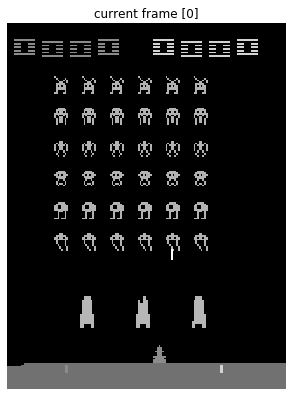

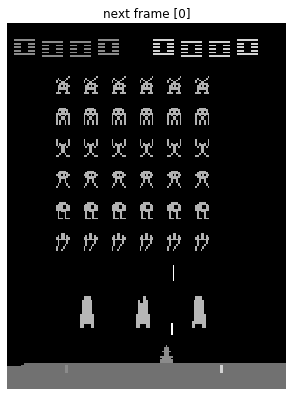

In [17]:
#get some information from  the batch to make sure it looks good.

import matplotlib.pyplot as plt

#frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env_train, batch_size)
frame_batch, next_frame_batch, actions_batch, next_actions_batch, reward_batch, frame_number_batch, lambda_reward_batch = get_train_batch(atari_env_train, batch_size, lambda_frames, gamma)

print("action: {}".format(actions_batch[0]))
print("reward: {}".format(reward_batch[0]))
print("frame:  {}".format(frame_number_batch[0]))

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("current frame [0]")
plt.imshow(frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("current frame [2]")
# plt.imshow(frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("next frame [0]")
plt.imshow(next_frame_batch[0][0], cmap="gray")
plt.axis("off")
plt.show()

# plt.figure(figsize=(11, 7))
# plt.subplot(121)
# plt.title("next frame [2]")
# plt.imshow(next_frame_batch[0][2], cmap="gray")
# plt.axis("off")
# plt.show()

In [19]:
for i in range(500):
    reward = atari_env_train.frame_buffer[-i].getReward()
    print(reward)

0.0
-5.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0